# Classifier

This notebook:

* Correctly reads in all data
* Explans my your sampling scheme
* Generates a training set and a validation set
* Successfully trains my classifier
* Plots of training and validation loss
* Reports validation accuracy of the classifier
* Explans loss function and hyperparameters

In [8]:
import numpy as np
from nn.nn import NeuralNetwork
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load and preprocess the dataset

In [9]:
pos_seqs = read_text_file('data/rap1-lieb-positives.txt')
pos_labels = [True] * len(pos_seqs)

In [3]:
neg_seqs_big = read_fasta_file('data/yeast-upstream-1k-negative.fa')

In [4]:
# Make a list of negative sequences to match positive sequence length
pos_seq_length = len(pos_seqs[0])
neg_seqs = []
for big_seq in neg_seqs_big:
    for i in range(len(big_seq) - pos_seq_length + 1):
        neg_seqs.append(big_seq[i:i+pos_seq_length])
neg_labels = [False] * len(neg_seqs)

In [5]:
# Combine sequences and labels
all_seqs = pos_seqs + neg_seqs
all_labels = pos_labels + neg_labels

## Balance classes

In [6]:
# Balance classes using sample_seqs
bal_seqs, bal_labels = sample_seqs(all_seqs, all_labels)

In [7]:
def train_val_split(X, y, val_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(X))
    split_idx = int(len(X) * (1 - val_size))
    
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    X_train = X[train_indices]
    X_val = X[val_indices]
    y_train = y[train_indices]
    y_val = y[val_indices]
    
    return X_train, X_val, y_train, y_val

# One-hot encode
X = one_hot_encode_seqs(bal_seqs)
y = np.array(bal_labels).reshape(-1, 1)

X_train, X_val, y_train, y_val = train_val_split(X, y)

## Create the classifier

In [10]:
nn_arch = [
    {'input_dim': X_train.shape[1], 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}
]

# Create and train the model
model = NeuralNetwork(
    nn_arch=nn_arch,
    lr=0.01,
    seed=42,
    batch_size=32,
    epochs=3,
    loss_function='bce'
)

## Train the Classifier

In [11]:
train_loss, val_loss = model.fit(X_train, y_train, X_val, y_val)

Epoch 1 of 3
Testing loss: 0.0044
Validation loss: 0.0007
Epoch 2 of 3
Testing loss: 0.0007
Validation loss: 0.0006
Epoch 3 of 3
Testing loss: 0.0006
Validation loss: 0.0005


## Plot the loss

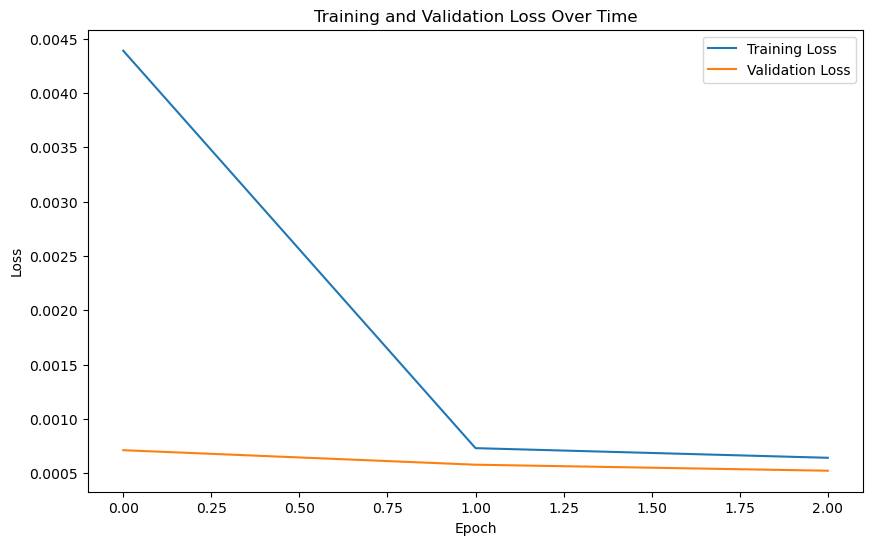

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

## Validation accuracy

In [18]:
def predict_in_batches(model, X, batch_size: int = 32):
    n_samples = X.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    y_hat = []

    for batch in range(n_batches):
        batch_begin_idx = batch * batch_size
        batch_end_idx = min(batch_begin_idx + batch_size, n_samples)
        X_batch = X[batch_begin_idx:batch_end_idx]

        y_hat_batch = model.predict(X_batch)
        y_hat.append(y_hat_batch)

    y_hat = np.concatenate([y.flatten() for y in y_hat]) 
    return y_hat.reshape((n_samples, -1))

batch_size = 32
y_pred = predict_in_batches(model, X_val, batch_size=batch_size)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = np.mean(y_pred_binary == y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9999



## Hyperparameter choices

**Architecture**
- 68 -> 32 -> 16 -> 1
- Nucleotides are 68 in len after being one-hot-encoded
- Gradual decrease down to prediction/classifier of size 1

**Learning Rate (0.01)**
- Small enough to get stable training but not too small to cause it to take too long.
- Tested iteratively to see what values seemed to work. 


**Batch Size (32)**
- larger batches give better training stability but smaller batches help with generalizability
- 32 was a good traidoff when training on my Mac


**Number of Epochs**
- It took a very long time to train, so I kept this number low. I was also having success with few epochs, so it worked out well

**Loss Function (BCE)**
- Binary cross entropy is the correct function to use for this task given the assignment, since it is useful as a classifier. 

**Activation Functions**
- ReLU in hidden layer:
   * Prevents vanishing gradients
- Sigmoid in output layer:
     * Matches normalized output range for prediction class [0,1]